<br>
<font>
<!-- <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" alt="SUT logo" width=300 height=300 align=left class="saturate"> -->
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=200 height=200>
<br>
<font color=0F5298 size=8>
Introduction to Machine Learning <br>
<font color=696880 size=5>
<!-- <br> -->
Computer Engineering Department
<br>
Sharif University of Technology

<font color=696880 size=5>
<br>
CE 40477 - Fall 2024

<font color=GREEN size=5>
<br>
Mahan Bayhaghi & Danial Gharib
<!-- <br> -->

____



In [7]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.9 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.cm as cm

# kNN classifier

In this section, we will implement a kNN classifier from scratch

In [9]:
class KNNClassifier:
    def __init__(self, k=3, distance_func=None):
        self.k = k  # number of neighbors to consider

        # If no custom distance function is provided, use Euclidean by default
        if distance_func is None:
            self.distance_func = self._euclidean_distance
        else:
            self.distance_func = distance_func  # user can pass their own distance function

    def fit(self, X, y):
        # Store the training data and labels for later comparison
        #a numpy array. NumPy arrays support vectorized math (like (x1 - x2) ** 2),
        #which is much faster than using Python lists.
        self.X_train = X
        self.y_train = y

    def _euclidean_distance(self, x1, x2):
        # Default distance: sqrt of sum of squared differences
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def _manhattan_distance(self, x1, x2):
        # Sum of absolute differences (L1 norm)
        return np.sum(np.abs(x1 - x2))

    def _minkowski_distance(self, x1, x2, p=3):
        # Generalized distance metric; for p=2 it's Euclidean, p=1 it's Manhattan
        return np.sum(np.abs(x1 - x2) ** p) ** (1 / p)

    def predict(self, X):
        predictions = []

        # Loop through each sample to predict
        for index, x in enumerate(X):
            # Compute distances from this sample to all training samples
            distances = [self.distance_func(x, x_train) for x_train in self.X_train]

            # Find the indices of the k smallest distances (nearest neighbors)
            k_indices = np.argsort(distances)[:self.k]

            # Get the labels of those nearest neighbors
            k_neighbor_labels = self.y_train[k_indices]

            # Count how many times each class appears among the neighbors
            counts = np.bincount(k_neighbor_labels.astype(int))

            # The predicted label is the one with the highest count (majority vote)
            predicted_label = np.argmax(counts)

            # Add the predicted label to the result list
            predictions.append(predicted_label)

        return np.array(predictions)  # return all predictions as a NumPy array



Using the kNN classifier defined, we can use different distance measures. Let us generate some random sample points:

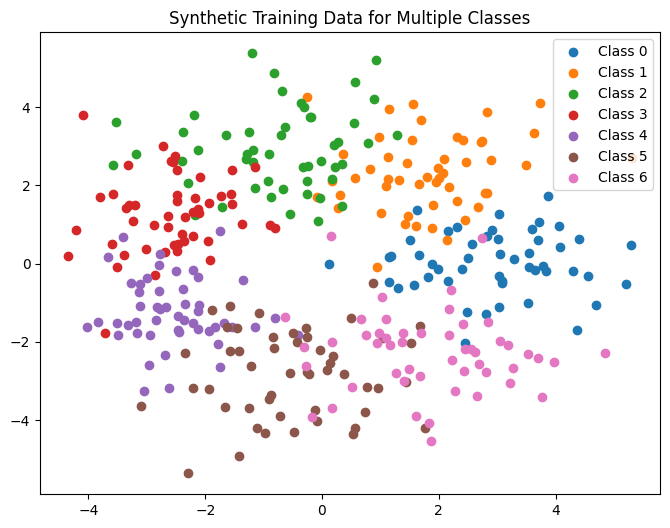

In [10]:
def generate_synthetic_data(m=3, num_points_per_class=100, cluster_std=1.0):
    np.random.seed(40)  # for reproducibility (always get the same data)

    X = []  # will hold all data points
    y = []  # will hold corresponding class labels
    means = []  # store center (mean) of each class cluster

    for i in range(m):  # for each class (e.g., 0 to m-1)
        angle = 2 * np.pi * i / m  # angle to spread classes evenly in a circle
        radius = 3  # fixed distance from origin
        mean = [radius * np.cos(angle), radius * np.sin(angle)]  # class center
        means.append(mean)

        # Diagonal covariance matrix (controls spread in x and y directions)
        cov = [[cluster_std, 0], [0, cluster_std]]

        # Generate data points from a Gaussian (normal) distribution
        class_data = np.random.multivariate_normal(mean, cov, num_points_per_class)

        X.append(class_data)  # add data of this class
        y += [i] * num_points_per_class  # label these points with class i

    # Stack all class data vertically into a single array (shape: m*num_points x 2)
    X = np.vstack(X)

    # Convert labels to a NumPy array
    y = np.array(y)

    return X, y, means


m = 7  # number of classes
num_points_per_class = 50
cluster_std = 1.0

X, y, class_means = generate_synthetic_data(m=m, num_points_per_class=num_points_per_class, cluster_std=cluster_std)

plt.figure(figsize=(8,6))
colors = plt.colormaps['tab10'].colors
for i in range(m):
    plt.scatter(X[y == i, 0], X[y == i, 1], color=colors[i], label=f'Class {i}')
plt.title('Synthetic Training Data for Multiple Classes')
plt.legend()
plt.show()


In [11]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

test_size = 0.2  # 20% for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

print(f"Total samples: {X.shape[0]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Total samples: 350
Training samples: 280
Testing samples: 70


Let us visualize as well:

In [13]:
def plot_decision_boundaries(classifier, X, y, means, title='Decision Boundaries'):
    # Determine the range of x and y based on the data, with some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1  # feature 1 range
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # feature 2 range

    h = 0.1  # step size for the grid resolution

    # Create a grid of points over the entire feature space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Flatten the grid to make a list of all points to predict on
    grid_points = np.c_[xx.ravel(), yy.ravel()]  # shape: (num_points, 2)

    # Predict the class of each point in the grid
    Z = classifier.predict(grid_points)

    # Reshape predictions back to grid shape for plotting
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))

    # Choose a categorical colormap with enough colors for all classes
    colors = plt.get_cmap('tab10', np.unique(y).size + 1)

    # Plot the filled contours (decision boundaries)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=colors)

    # Scatter plot of the actual data points, colored by class
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors, edgecolor='k', s=40)

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Add a legend for class labels
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=f'Class {i}',
                   markerfacecolor=colors(i), markersize=10) for i in range(np.unique(y).size)
    ], loc='upper right')

    plt.show()


In [14]:
distance_func = euclidean_distance

k = 5
knn = KNNClassifier(k=k, distance_func=distance_func)
knn.fit(X_train, y_train)

In [ ]:
plot_decision_boundaries(
    classifier=knn,
    X=X_train,
    y=y_train,
    means=class_means,
    title=f'kNN Decision Boundaries (k={k}, Distance=Euclidean)'
)

In [ ]:
k_values = range(1, 36)

accuracies = []

for k in k_values:
    knn = KNNClassifier(k=k, distance_func=euclidean_distance)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# plotting Accuracy for different values of k
plt.figure(figsize=(10,6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('kNN Classification Accuracy for Different k Values')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()